<a href="https://colab.research.google.com/github/bala-baskar/nlp_specialization/blob/main/codes/b4_nlp_with_transformers/chapter_2_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 2 - Text Classification

- Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language.
-  In this chapter, we’ll tackle this task using a variant of BERT called DistilBERT.1 The main advantage of this model is that it achieves comparable performance to BERT, while being significantly smaller and more efficient.  
- This enables us to train a classifier in a few minutes, and if you want to train a larger BERT model you can simply change the checkpoint of the pretrained model.

- A checkpoint corresponds to the set of weights that are loaded into a given transformer architecture.

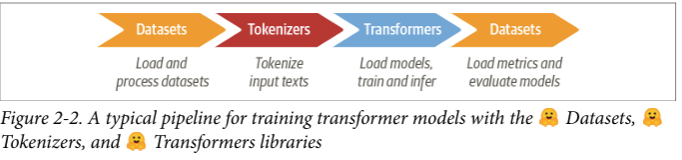

## The Dataset

In this example, given a tweet, our task will be train a model that can classify the text to one of the six basic emotions: anger, disgust, fear, joy, sadness and surprise

In [1]:
# Quick look at Hugging face datasets
try:
  from datasets import load_dataset
except ModuleNotFoundError:
  !pip -q install datasets
  from datasets import load_dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.9 MB/s eta 0:00:00


In [2]:
#Load the emotion dataset
emotions = load_dataset("emotion")
print(emotions)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [3]:
# Train data
train_ds = emotions['train']
print("Length of train data:",len(train_ds))
print("First row of train data:", train_ds[0]) # first row
print("Column names in train data:",train_ds.column_names)

Length of train data: 16000
First row of train data: {'text': 'i didnt feel humiliated', 'label': 0}
Column names in train data: ['text', 'label']


 This reflects the fact that HF Datasets is based on Apache Arrow, which defines a typed columnar format that is more memory efficient than native Python.

In [4]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [5]:
# First 5 rows
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


### What if My Dataset is not on the Hub?

```python
# method 1
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
!wget {dataset_url}
!head -n 1 train.txt
emotions_local = load_dataset("csv", data_files="train.txt", sep=";",names=["text", "label"])

# method 2
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", names=["text", "label"])
```




### Datasets to Dataframes

To enable the conversion,  Datasets provides a set_format() method that allows us to change the output format of the Dataset. Note that this does not change the underlying data format (which is an Arrow table), and you can switch to another format later if needed

In [6]:
import pandas as pd

emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
# Get label name for label in integers
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


As Andrej Karpathy notes in his famous blog post [“A Recipe for Training Neural Networks”](https://oreil.ly/bNayo), becoming “one with the data” is an essential step for training great models!

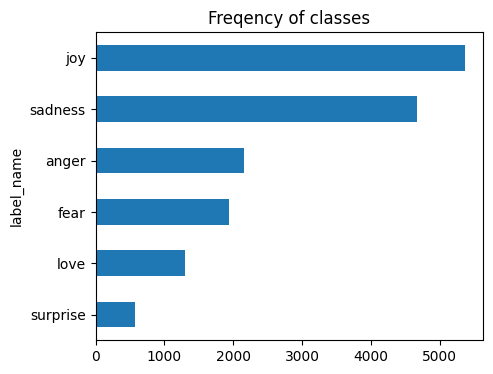

In [8]:
# Class distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Freqency of classes")
plt.show()

- In this case, the dataset is heavily imbalanced. There are several ways to deal with imbalanced data, including:
  - Randomly oversample the minority class
  - Randomly undersample the majority class
  - Gather more labeled data from the underrepresented classes

- For more on sampling techniques, explore this library [Imbalanced-learn](https://oreil.ly/5XBhb)

<Figure size 500x400 with 0 Axes>

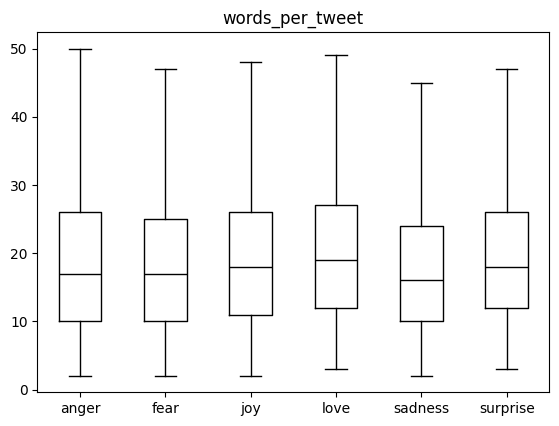

In [9]:
# How long are the tweets
plt.figure(figsize=(5,4))
df['words_per_tweet'] = df['text'].str.split().apply(len)
df.boxplot("words_per_tweet",by='label_name',grid=False,
           showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

- Transformer models have a maximum input sequence length that is referred to as the maximum context size.
- For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text.
-  Texts that are longer than a model’s context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information

In [10]:
# reset the output format of the dataset
emotions.reset_format()

### From Text to Tokens

Transformer models like DistilBERT cannot receive raw strings as inputs; instead they are assume that text has been tokenized and encoded as numerical vectors.

- Tokenization is the step of breaking down a string into the atomic units used in the model.
- There are several tokenization strategies one can adopt, and the optimal splittings of words into subunits is usually learned from the corpus
- 3 types:
  1. Character tokenization - feed each character individually to the model
  2. Word tokenization -
  3. SubWord tokenization

#### 1. Character tokenization

In [11]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print("Tokenized text:\n",tokenized_text)
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print("Numerical encoded tokens :\n",token2idx)
input_ids = [token2idx[token] for token in tokenized_text]
print("Input ids :\n",input_ids)

Tokenized text:
 ['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']
Numerical encoded tokens :
 {' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}
Input ids :
 [5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


The last step is to convert input_ids to a 2D tensor of one-hot vectors. One-hot vectors are frequently used in machine learning to encode categorical data, which can be either ordinal or nominal.

In [12]:
import torch
import torch.nn.functional as F
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [13]:
# first vector
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


**Drawbacks**
1. Character-level tokenization ignores any structure in the text and treats the whole string as a stream of characters. (but helps deal with misspellings and rare words)
2. It fails to hold the Linguistic structures such as words need to be learned from the data.
3. It requires significant compute, memory and data

#### 2. Word Tokenization

Instead of splitting the text into characters, we can split it into words and map each word to an integer. Using words from the outset enables the model to skip the step of learning words from characters, and thereby reduces the complexity of the training process.

In [14]:
tokenized_text = text.split() # using whitespace to tokenize the text
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


**Drawbacks**  
Punctuation is not accounted for, so NLP. is treated as a single token. Given that words can include declinations, conjugations, or misspellings, the size of the vocabulary can easily grow into the millions!

- Some word tokenizers have extra rules for punctuation. One can apply stemming, lemmatization, which normalizes words to their stem

```💡 Having a large vocabulary is a problem because it requires neural networks to have an enormous number of parameters. To illustrate this, suppose we have 1 million unique words and want to compress the 1-million-dimensional input vectors to 1-thousanddimensional vectors in the first layer of our neural network. This is a standard step in most NLP architectures, and the resulting weight matrix of this first layer would contain 1 million × 1 thousand = 1 billion weights. This is already comparable to the largest GPT-2 model,4 which has around 1.5 billion parameters in total!```

A common approach is to limit the vocabulary and discard rare words by considering, say, the 100,000 most common words in the corpus. Words that are not part of the vocabulary are classified as “unknown” and mapped to a shared UNK token. This means that we lose some potentially important information in the process of word tokenization, since the model has no information about words associated with UNK.

#### 3. Subword Tokenization

 - On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings.
 - On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size.
 - The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is learned from the pretraining corpus using a mix of statistical rules and algorithms.

In [15]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
# WordPiece which is used by the BERT and DistilBERT tokenizers
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
encoded_text = tokenizer(text)
print(encoded_text)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


The AutoTokenizer class belongs to a larger set of “auto” classes whose job is to automatically retrieve the model’s configuration, pretrained weights, or vocabulary from the name of the checkpoint.

In [16]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


1. [CLS] and [SEP] tokens have been added to the start and end of the sequence
2. Tokens are lowercased
3. The **##** prefix in **##izing** and **##p** means that the preceding string is not whitespace; any token with this prefix should be merged with the previous token when you convert the tokens back to a string.

In [17]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [18]:
# AutoTokenizer attributes
print("Vocabulary size: ",tokenizer.vocab_size)
print("Model's maximum context size:",tokenizer.model_max_length)
print("Model input names:", tokenizer.model_input_names)

Vocabulary size:  30522
Model's maximum context size: 512
Model input names: ['input_ids', 'attention_mask']


💡 When using pretrained models, it is really important to make sure that you use the same tokenizer that the model was trained with. From the model’s perspective, switching the tokenizer is like shuffling the vocabulary. If everyone around you started swapping random words like “house” for “cat,” you’d have a hard time understanding what was going on too!

In [19]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

print(emotions['train'][:2])
print(tokenize(emotions["train"][:2]))

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'], 'label': [0, 0]}
{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


 - `padding=True` will pad the examples with zeros to the size of the longest one in a batch
 - `truncation=True` will truncate the examples to the model’s maximum context size.

|Spl token| [PAD] | [UNK] | [CLS] | [SEP] | [MASK] |
|---|---|---|---|---|---|
|Spl Token ID| 0 | 100 | 101 | 102 | 103 |

-  the attention mask allows the model to ignore the padded parts of the input.

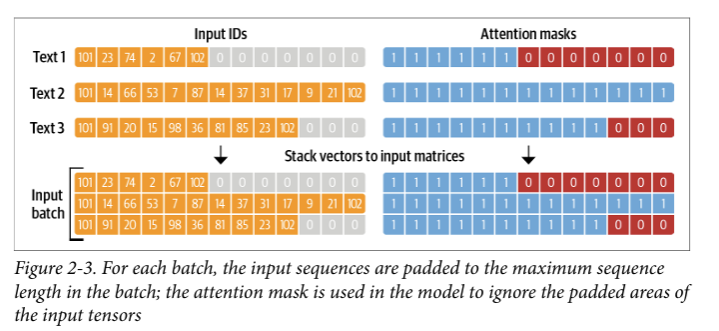

In [20]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier

- Models like DistilBERT are pretrained to predict masked words in a sequence of text. However, we cant use these language models directly for text classification, we need to modify them slightly

Below is the architecture of an encoder-based model like DistilBERT

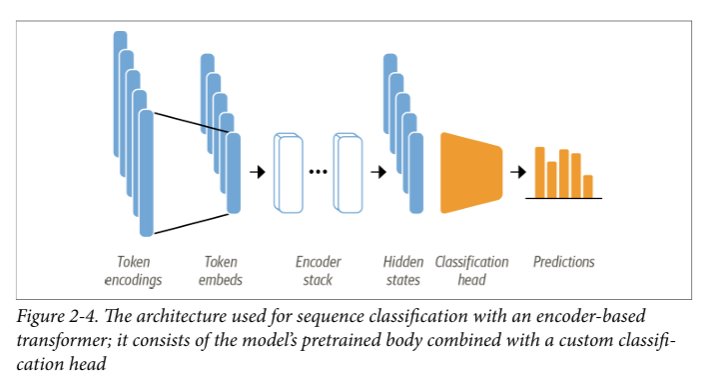

1. The text is tokenized and represented as one-hot vectors called `token encodings`
2. The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of `20k-200k unique tokens`
3. These token encodings are converted to `token embeddings`, which are vectors living in a lower dimensional space
4. The token embeddings are then passed through the encoder block layers to yield a `hidden state` for each input token
5. For the pretraining objective of language modeling, each hidden state is fed to a layer that predicts the masked input tokens.
6. For the classification task, we replace the language modeling layer with a classification layer

**Note**  
In practice, PyTorch skips the step of creating one-hot vectors for token encodings because multiplying a matrix with a one-hot vector is the same as selecting a column from the matrix. This can be done directly by getting the column with the token ID from the matrix.

We have two options to train such a model on our Twitter dataset:  
**1. Feature extraction** - We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.  
**2. Fine-tuning** - We train the whole model end-to-end, which also updates the parameters of the pretrained model.

### Transformers as Feature Extractors

- We freeze the body's weights during training and use the hidden states as features for the classifier
- We can train a small aor shallow model.
- This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once

In [21]:
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

- The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states.

In [22]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [23]:
inputs = {k:v.to(device) for k,v in inputs.items()}
print(inputs)
with torch.no_grad(): # used context manager to disable the automatic calculation of grad
  outputs = model(**inputs)
print(outputs)

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}
BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [24]:
outputs.last_hidden_state.size() #[batch_size, n_tokens,hidden_dim]

torch.Size([1, 6, 768])

- For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature.

In [25]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [26]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [27]:
# model expects tensors as inputs
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [28]:
# Creating a feature matrix
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [29]:
# Visualizing the training set
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.652533,6.465142,0
1,-2.792951,6.080271,0
2,5.259743,3.001746,3
3,-2.218374,3.895544,2
4,-3.168882,4.040971,3


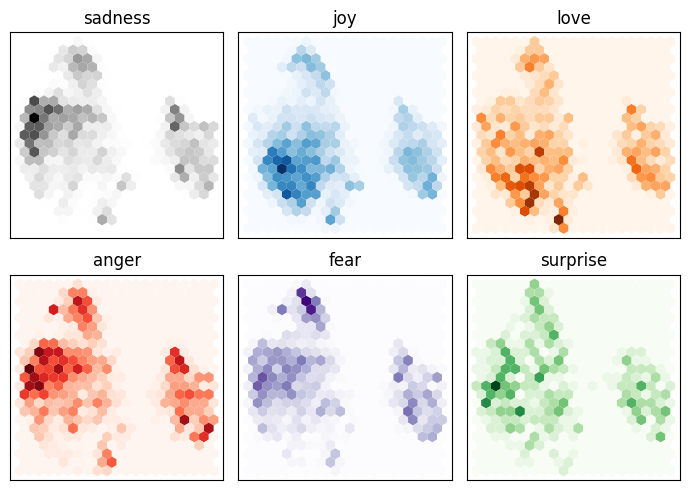

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                 gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [31]:
# Training a simple classifier
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [32]:
# Comparing the simple classifier with naive/dummy baseline
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

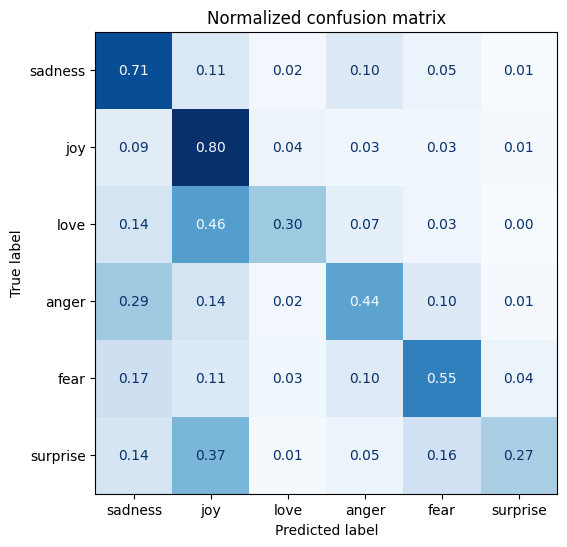

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-tuning Transformers

- With the fine tuning approach, we do not use the hidden states as fixed features, but instead train them.
- This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification

In [34]:
# Loading a pretrained model
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 - The only slight modification is that we use the `AutoModelFor SequenceClassification` model instead of `AutoModel`. The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.
 - We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head

In [35]:
# Defining the performance metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [46]:
# Training the model
import os
from transformers import Trainer, TrainingArguments

push_hub = False
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
if push_hub:
  model_name = f"{model_ckpt}-finetuned-emotion"
  push_to_hub = True
else:
  model_name = os.getcwd()
  push_to_hub = False
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=push_to_hub,
                                  log_level="error",
                                  report_to="none") # report to none added to switch of logs to wandb/mlflow

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


- `push_to_hub = True` to push the model resutls to HuggingFace hub, for which login needed using below line of code:
```python
from huggingface_hub import notebook_login   
notebook_login()
```

In [47]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

<ipython-input-47-5240f26dbeec>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.835700,0.309361,0.910000,0.909601
2,0.253000,0.218151,0.924000,0.923942


{'test_loss': 0.21815146505832672, 'test_accuracy': 0.924, 'test_f1': 0.923942408630886, 'test_runtime': 3.9082, 'test_samples_per_second': 511.739, 'test_steps_per_second': 8.188}


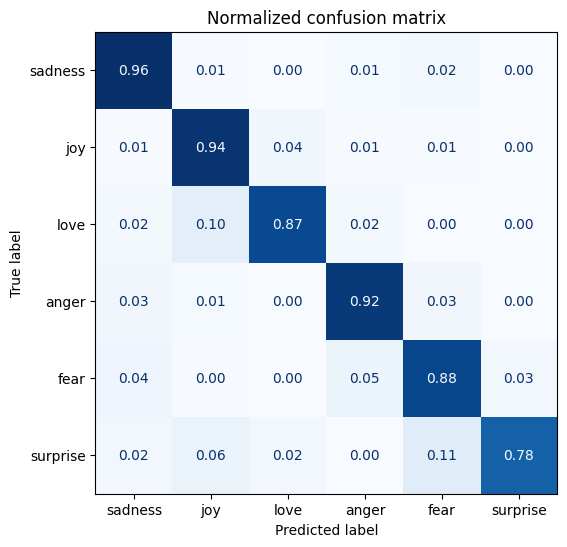

In [48]:
preds_output = trainer.predict(emotions_encoded["validation"])
print(preds_output.metrics)
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

### Error analysis

 A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned

In [49]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  # Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items()
  if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(),
          "predicted_label": pred_label.cpu().numpy()}

In [50]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [51]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,6.046185
1801,i feel that he was being overshadowed by the s...,love,sadness,5.816125
1963,i called myself pro life and voted for perry w...,joy,sadness,5.502698
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.411175
1950,i as representative of everything thats wrong ...,surprise,sadness,5.026318
1274,i am going to several holiday parties and i ca...,joy,sadness,5.014690
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.903338
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.734885
1509,i guess this is a memoir so it feels like that...,joy,fear,4.329785
1111,im lazy my characters fall into categories of ...,joy,fear,4.233242


- We can clearly see that the model predicted some of the labels incorrectly. On the other hand, it seems that there are quite a few examples with no clear class, which might be either mislabeled or require a new class altogether.
- When looking at the samples with the lowest losses, we observe that the model seems to be most confident when predicting the `joy` class.

In [52]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.015816
131,i feel like a graph doesnt show the data accur...,joy,joy,0.016169
1090,i dont know what it is about me and sweets the...,joy,joy,0.016251
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.016373
632,i feel he is an terrific really worth bet,joy,joy,0.016404
578,i got to christmas feeling positive about the ...,joy,joy,0.016521
620,i shall move right along to the post interview...,joy,joy,0.016780
452,i manage to complete the lap not too far behin...,joy,joy,0.016880
1263,i feel this way about blake lively,joy,joy,0.017035
1513,i have also been getting back into my gym rout...,joy,joy,0.017080


### Saving and sharing the model

NLP community benefits greatly from sharing pretrained and fine-tuned models, and everybody can share their models with others via the Hugging Face Hub

```python
trainer.push_to_hub(commit_message='Training completed!')
```

After pushing the model to Hub, we can now use it with `pipeline()` function, to load and predict
```python
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)
```

Then test the pipline with sample tweet:
```python
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)
```

Finally the probability plot:
```python
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()
```

### THE END